In [4]:
cat('Updated ', date())

Updated  Tue Oct 11 17:05:23 2022

_This is a study note while I am taking __Generalized Linear Models and Nonparametric Regression__ offered by University of Colorado Boulder in Coursera_

# Poisson Regression on Real Data in R

The goal of the __bike__ data is to keep count of cyclists entering and leaving Queens, Manhattan and Brooklyn vis the East River information Management system collected this count data for several during 2017.

Our goal will be to try to come up with a __Poission regression model__ that uses the weather data to explain or predict the total number of cyclists on the Manhattan Bridge on any given day dring the period.

* date: Date the count was conducted
* day: Day of the week the count was conducted
* temp_h: The high temperature for that day in fahrenheit
* temp_l: The low of temperture for that night in harenheit
* precip: The amoung of precipitaion for that day in inches
* bb: Total number of cyclist counts at Brooklyn Bridge in a 24 hour period
* mb: Total number of cyclist counts at Manhatttan Bridge in a 24 hour period
* wb: Total number of cyclist counts at Williamburg Bridge in a 24 hour period
* qb: Total number of cyclist counts at Queensboro Bridge in a 24 hour period
* total: The number of cyclist counts for all the East River Bridges combined in a 24 hour period

## 1. Data preparation

In [5]:
url <- 'https://raw.githubusercontent.com/bzaharatos/-Statistical-Modeling-for-Data-Science-Applications/master/Generalized%20Linear%20Models%20and%20Nonparametric%20Regression/Datasets/2017%20Monthly%20Bike%20Count%20Totals%20for%20East%20River%20Bridges/bike.csv'
bike <- read.csv(url, sep = ",", header=TRUE)

In [6]:
head(bike, 10)

,ï..date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4/1,Saturday,46.0,37.0,0.00,606,1446,1915,1430,5397
2,4/2,Sunday,62.1,41.0,0.00,2021,3943,4207,2862,13033
3,4/3,Monday,63.0,50.0,0.03,2470,4988,5178,3689,16325
4,4/4,Tuesday,51.1,46.0,1.18,723,1913,2279,1666,6581
5,4/5,Wednesday,63.0,46.0,0.00,2807,5276,5711,4197,17991
6,4/6,Thursday,48.9,41.0,0.73,461,1324,1739,1372,4896
7,4/7,Friday,48.0,43.0,T,1222,2955,3399,2765,10341
8,4/8,Saturday,55.9,39.9,0.00,1674,3163,4082,2691,11610
9,4/9,Sunday,66.0,45.0,0.00,2375,4377,4886,3261,14899


Note: _T_ =  trace precipitation.

In [7]:
# check for NA, somtime missing values are recored as 99999...
sum(is.na(bike$mb))

[1] 0

In [8]:
# rename the first variale as date
names(bike)[1] <- "date"

In [9]:
names(bike)

[1] "date"   "day"    "temp_h" "temp_l" "precip" "bb"     "mb"     "wb"    
 [9] "qb"     "total"

In [10]:
# install.packages('tidyverse')

In [11]:
library(tidyverse)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.3.6      v purrr   0.3.5 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [12]:
#replace T for 0
bike$precip[6:7]
typeof(bike$precip)

bike = bike %>%
            mutate(precip = fct_recode(precip, "0" = "T"))

[1] "0.73" "T"

[1] "character"

In [136]:
# check that trace precip is now zero
bike$precip[6:7]
typeof(bike$precip)

head(bike, 10)

[1] 0.73 0   
44 Levels: 0.00 0.01 0.02 0.03 0.04 0.06 0.07 0.08 0.09 0.10 0.11 0.13 ... 0

[1] "integer"

,date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
,<chr>,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4/1,Saturday,46.0,37.0,0.00,606,1446,1915,1430,5397
2,4/2,Sunday,62.1,41.0,0.00,2021,3943,4207,2862,13033
3,4/3,Monday,63.0,50.0,0.03,2470,4988,5178,3689,16325
4,4/4,Tuesday,51.1,46.0,1.18,723,1913,2279,1666,6581
5,4/5,Wednesday,63.0,46.0,0.00,2807,5276,5711,4197,17991
6,4/6,Thursday,48.9,41.0,0.73,461,1324,1739,1372,4896
7,4/7,Friday,48.0,43.0,0,1222,2955,3399,2765,10341
8,4/8,Saturday,55.9,39.9,0.00,1674,3163,4082,2691,11610
9,4/9,Sunday,66.0,45.0,0.00,2375,4377,4886,3261,14899


Now precip variable changed to integer without "T"

In [13]:
# check data types
sapply(bike, class)

date         day      temp_h      temp_l      precip          bb 
"character" "character"   "numeric"   "numeric"    "factor"   "numeric" 
         mb          wb          qb       total 
  "numeric"   "numeric"   "numeric"   "numeric"

In [14]:
# warngle the data
bike <- bike %>%
        mutate(date = as.Date(as.character(date), format='%m/%d')) %>%
        mutate(precip = as.numeric(as.character(precip)))

# fix the year of the date variable 
library(lubridate) # for the ymd() function
bike$date = ymd(as.character(bike$date)) - years(5)

# make day as factor
bike$day <- as.factor(bike$day)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




Without year, R gives the current year, so we subtract 5 to make 2017 since the data was recorded in 2017.

In [15]:
bike$date[1:5]

[1] "2017-04-01" "2017-04-02" "2017-04-03" "2017-04-04" "2017-04-05"

In [142]:
# summarize and confirm data types
summary(bike)
sapply(bike, class)
head(bike)

      date                   day         temp_h         temp_l     
 Min.   :2017-04-01   Friday   :30   Min.   :46.0   Min.   :37.00  
 1st Qu.:2017-05-24   Monday   :31   1st Qu.:66.9   1st Qu.:55.23  
 Median :2017-07-16   Saturday :31   Median :75.9   Median :64.00  
 Mean   :2017-07-16   Sunday   :31   Mean   :74.2   Mean   :62.03  
 3rd Qu.:2017-09-07   Thursday :30   3rd Qu.:82.0   3rd Qu.:70.00  
 Max.   :2017-10-31   Tuesday  :31   Max.   :93.9   Max.   :78.10  
                      Wednesday:30                                 
     precip             bb             mb             wb             qb      
 Min.   :0.0000   Min.   : 151   Min.   : 484   Min.   : 874   Min.   : 865  
 1st Qu.:0.0000   1st Qu.:2298   1st Qu.:4308   1st Qu.:5115   1st Qu.:3746  
 Median :0.0000   Median :2857   Median :5608   Median :6287   Median :4681  
 Mean   :0.1318   Mean   :2680   Mean   :5345   Mean   :6052   Mean   :4550  
 3rd Qu.:0.0375   3rd Qu.:3285   3rd Qu.:6760   3rd Qu.:7512   3rd

date       day    temp_h    temp_l    precip        bb        mb        wb 
   "Date"  "factor" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
       qb     total 
"numeric" "numeric"

,date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017-04-01,Saturday,46.0,37,0.00,606,1446,1915,1430,5397
2,2017-04-02,Sunday,62.1,41,0.00,2021,3943,4207,2862,13033
3,2017-04-03,Monday,63.0,50,0.03,2470,4988,5178,3689,16325
4,2017-04-04,Tuesday,51.1,46,1.18,723,1913,2279,1666,6581
5,2017-04-05,Wednesday,63.0,46,0.00,2807,5276,5711,4197,17991
6,2017-04-06,Thursday,48.9,41,0.73,461,1324,1739,1372,4896


Nota that if there is 0 or 999.. in the summary date, we might need to think about missing values. In our example, we see that each variable is stored correctly.

In [114]:
bike$Date <-as.Date(bike$Date)

ERROR: Error in `$<-.data.frame`(`*tmp*`, Date, value = structure(numeric(0), class = "Date")): replacement has 0 rows, data has 214


## 2. Modelling

We split the data into a training set (80%) and a test set(20%)

In [143]:
set.seed(8585)
bound = floor(nrow(bike)*0.8) # define % of training and test

df = bike[sample(nrow(bike)), ] # sample rows
df_train = df[1:bound, ] # get training set
df_test = df[(bound+1):nrow(bike), ] # get test set

We fit a Poisson regression model on the data.

In [146]:
# Generalized linear models, family=poission which is exponential family
glm_bike = glm (mb ~ precip + temp_h + temp_l + day, data=df_train, 
                family=poisson)

In [152]:
summary(glm_bike)

# Interprecataion of precip. variable
cat("If precipitaton is increased by one inch, we would expect the mean number of bikes across the Manhattan Bridge to be mutiplied by about", exp(coef(glm_bike)[2]),". So, half the numer of bikes.")


Call:
glm(formula = mb ~ precip + temp_h + temp_l + day, family = poisson, 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-41.577   -7.122    2.309    8.523   38.973  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   7.7605007  0.0088089  880.98   <2e-16 ***
precip       -0.6733753  0.0049519 -135.98   <2e-16 ***
temp_h        0.0232326  0.0002333   99.59   <2e-16 ***
temp_l       -0.0139666  0.0002524  -55.34   <2e-16 ***
dayMonday     0.0758621  0.0038756   19.57   <2e-16 ***
daySaturday  -0.1993917  0.0042215  -47.23   <2e-16 ***
daySunday    -0.2618583  0.0043404  -60.33   <2e-16 ***
dayThursday   0.0999425  0.0038607   25.89   <2e-16 ***
dayTuesday    0.1419263  0.0038452   36.91   <2e-16 ***
dayWednesday  0.1580572  0.0038413   41.15   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 110729  on 17

If precipitaton is increased by one inch, we would expect the mean number of bikes across the Manhattan Bridge to be mutiplied by about 0.5099843 . So, half the numer of bikes.

Now, verify this interpretation.

In [162]:
# a new covariabe class based on the second row of the test set and
# take fifth coloum (precipitation variable) and then adding 1
newdata = df_test[2, ]; newdata[5] = newdata[5] + 1 ; newdata 

# predict1 using original data, predict2 using new data
predict1 = predict(glm_bike, df_test[2,], type = "response")
predict2 = predict(glm_bike, newdata, type = "response")

cat("The precip estimate times the original prediction is", exp(coef(glm_bike)[2])*predict1, ".")
cat("The prediction for a one inch increase in precip (holding other predictors constant) is", predict2, ".")

,date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2017-04-02,Sunday,62.1,41,1,2021,3943,4207,2862,13033


The precip estimate times the original prediction is 2198.176 .THe prediction for a one inch increase in precip (holding other predictors constant) is 2198.176 .

This is helpful in understanding some of relationshio between precipitation and the number of cyclists that cross the Manhattan Bridge. 

We now want to know what a one standard deviation increse would loook like. To do so, we need to scale the data and note the standard deviation of the precipitation variable in the training set.

In [172]:
cat("The standard deviation of precipitation is", sd(df_train$precip),".")
df_train_scale = df_train %>% mutate_at(c("precip", "temp_h", "temp_l"), scale)
# scale  = ( xi - mean of x )/sd of x

The standard deviation of precipitation is 0.3755631 .

We now fit a Poission regression again with the scaled data.

In [174]:
glm_bike_scale = glm(mb ~ precip + temp_h + temp_l + day, data=df_train_scale, family=poisson)
coef(glm_bike_scale)

(Intercept)       precip       temp_h       temp_l    dayMonday  daySaturday 
  8.52140068  -0.25289490   0.23726473  -0.12827691   0.07586209  -0.19939172 
   daySunday  dayThursday   dayTuesday dayWednesday 
 -0.26185827   0.09994253   0.14192629   0.15805716

In [189]:
cat(paste0("Assuming the model is correct, if precipitation is increased by ",
           "one standard deviation (0.38 inches), we would expect the mean ",
           "number of bikes across the Manhattan bridge to be mulpitlied by ",
           exp(coef(glm_bike_scale)[2]),
           " adjusting for temperatures and day of week"))

Assuming the model is correct, if precipitation is increased by one standard deviation (0.38 inches), we would expect the mean number of bikes across the Manhattan bridge to be mulpitlied by 0.776549495020493 adjusting for temperatures and day of week

We have not studied whether this model is correct. One simple assessment is that we can a plot of __the predicted values $\hat\mu$ vs the true values__ of either the training set, or the test set.  We will discuss detaied assessment methods later.

 We should expect

* If the predicted values vs true valeus is lining up along the line Y=X
* If the predictions were perfect, every point in the following plot would line up along the line. 

`geom_smooth()` using formula 'y ~ x'



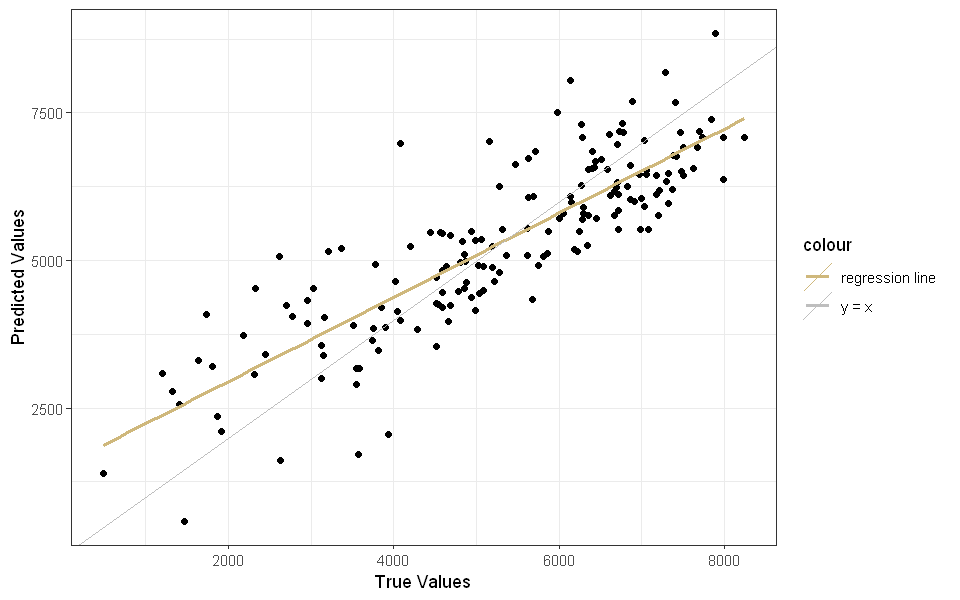

In [197]:
n_train = length(df_train$mb)
n_test = length(df_train$mb)

mu_train = predict(glm_bike, df_train, type="response")
y_train = df_train$mb

options(repr.plot.width = 8, repr.plot.height=5)
df_test_predict = data.frame(y_train, mu_train)
p = ggplot(df_test_predict) + geom_point(aes(y_train, mu_train))
p = p + geom_smooth(aes(y_train, mu_train, col = '#CFB87C'), method = "lm", se=FALSE)
p = p + geom_abline(aes(intercept = 0, slope = 1, col = "grey"))
p = p + scale_color_identity(labels= c("regression line", "y = x"), guide="legend")
p = p + theme_bw()
p = p + xlab("True Values") + ylab("Predicted Values")
p

If a model is appropriate, values are lining very tightly on the y=x. In this case, it does not look that tight. We might need to fit anther model.

The same plot on the test set shows a bit more variability, includint as further suggesting that the mode fit is less than optimal. 

`geom_smooth()` using formula 'y ~ x'



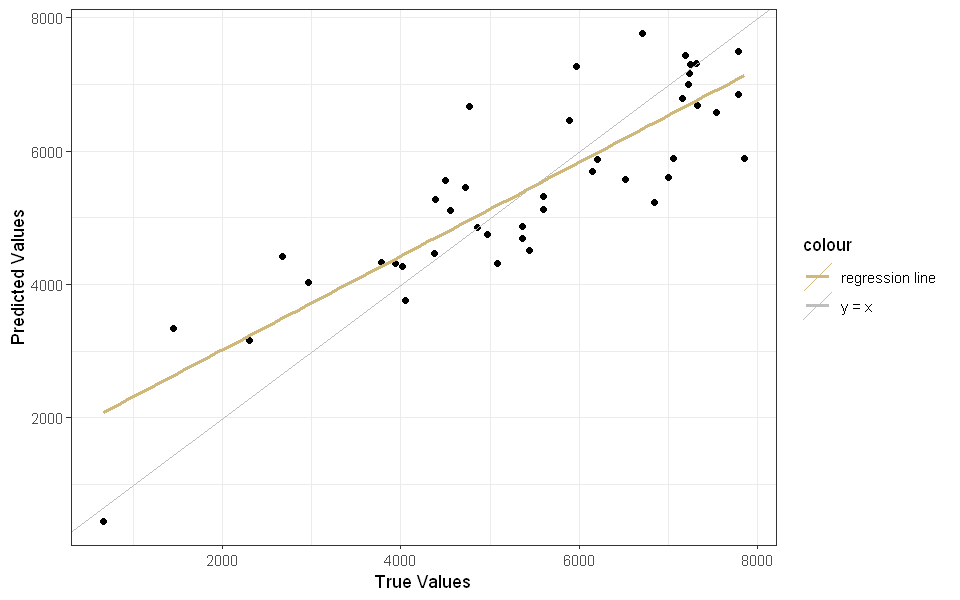

In [198]:
n_train = length(df_train$mb)
n_test = length(df_train$mb)

mu_test = predict(glm_bike, df_test, type="response")
y_test = df_test$mb

options(repr.plot.width = 8, repr.plot.height=5)
df_test_predict = data.frame(y_test, mu_test)
p = ggplot(df_test_predict) + geom_point(aes(y_test, mu_test))
p = p + geom_smooth(aes(y_test, mu_test, col = '#CFB87C'), method = "lm", se=FALSE)
p = p + geom_abline(aes(intercept = 0, slope = 1, col = "grey"))
p = p + scale_color_identity(labels= c("regression line", "y = x"), guide="legend")
p = p + theme_bw()
p = p + xlab("True Values") + ylab("Predicted Values")
p

All of that suggests that we could do a bit better in our model.